# Music Generation with an LSTM Network

## Data Source: Classical Music MIDI ([kaggle](https://www.kaggle.com/soumikrakshit/classical-music-midi))
### I use only the Chopin MIDI files scraped from [here](http://www.piano-midi.de/chopin.htm)

In [1]:
# Load functions from music21 (https://web.mit.edu/music21/doc/)to be used for parsing MIDI files
from music21 import converter, instrument, note, chord, key, tempo, duration, stream

import numpy as np
import pandas as pd

from os import listdir, path
from sys import maxsize, getsizeof
np.set_printoptions(threshold=maxsize)

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

## Data Preparation

In [2]:
def read_midi(file, time_tol = 1.e-3):
    """This function reads a midi file for the notes, offsets, and durations for the piano relevant piano part.
    The data needs to be further processed because there are many notes occurring at identical offsets (meaning 
    they start at the same time) but have different durations. For a more sequential representation, I convert 
    this data into a sequence in which there is no overlap, i.e. any time there is a change in the state of the 
    piano keyboard, a new element is created describing this state along with a duration for that state. This 
    format will be much easier to use for encoding the data into the LSTM network input later on. These 
    sequences, are  returned along with the musical keys (keys instead of key because there are key changes) 
    of the song (we need this because we will eventually transpose everything to the key of C.)"""
    
    print("Loading MIDI File:", file)

    midi = converter.parse(file)                    # will extract the parsed data with all
    parts = instrument.partitionByInstrument(midi)  # separated into instructions for different instruments

    for part in parts:
        # There is one viable part per song, we'll return this one when we find it
        notes_to_parse = part.recurse()
        notes = []        # This list will form the values of notes_by_part
        keys = []         # A list will contain the musical keys (one element per part)
        
        bpm = None        # Beats per minute, this changes a lot throughout the song.
                          # I will use to scale durations
                    
        offset = 0        # the offset is the number (float value) of beats (AKA quarter notes)
                          # into a song the notes we are currently reading in begin at.
        last_offset = 0   # keeps track of the offset out to which we've alread written data from
        
        all_notes_ato = []  # All notes At This Offset (ATO). Tracks the notes that need to
                            # be added in between two offsets

        for element in notes_to_parse: 

            if (getattr(element, '__module__', None) == instrument.__name__):  
                continue       # ignore the instrument type. Could enforce that it must
                               # be piano type but one of the files is misclassed, but
                               # still has the information of all the notes.
            if (isinstance(element, note.Rest)):            # Ignore rests in the file, I will infer them 
                continue                                      # from the offsets and durations
                    
            if (isinstance(element, key.Key)):                
                
                if (keys):   # already a key instance has been found in this part. This is a key change.
                             # I will later treat these occurrences as new songs in different keys.
                    notes.append('key change')    # a marker for separation later
                        
                keys.append(str(element))          # Store the keys in order of appearance
                
            elif (isinstance(element, tempo.MetronomeMark)):  # Update bpm (the files are riddled with these)
                bpm = element.number  
                
            else:
                
                if (bpm is None):
                    print('bpm is None before first note or chord, skipping part')
                    notes.clear()
                    break          
                    
                if (element.offset == last_offset):   # We're still at this offset, so keep adding to all_notes_ato
                    
                    if (isinstance(element, note.Note)):     
                        all_notes_ato.append((str(element.pitch), element.duration.quarterLength))
                        
                    elif (isinstance(element, chord.Chord)):
                        all_notes_ato.append(('.'.join(str(n) for n in element.pitches), \
                                                           element.duration.quarterLength))                                   
                else:    # a new offset, we need to write all the different piano states that
                         # occurred in this offset interval, and add a rest if the offset interval
                         # is longer than the durations of any of the notes or chords
                    offset = element.offset    
                    cur_offset = last_offset        
                    
                    if (all_notes_ato):   # We have notes to write at this offset
                        
                        all_notes_ato.sort(key = lambda x: x[1])   # sort by duration
                        while(cur_offset < offset):  
                            
                            shortest_duration = all_notes_ato[0][1]
                            if (shortest_duration < (offset - cur_offset)):    # write some intermediate
                                                                               # lines, for those notes
                                                                               # whose durations fall in
                                                                               # this offset interval
                                notes.append(('.'.join(n[0] for n in all_notes_ato), \
                                            all_notes_ato[0][1] * (60 / bpm)))    # convert to seconds
                                cur_offset += shortest_duration
                                
                                # Now get rid of those notes we just wrote
                                while(all_notes_ato and all_notes_ato[0][1] == shortest_duration):
                                    all_notes_ato.pop(0)
                                    
                                if (not all_notes_ato):
                                    # If there are no notes to write and there is still a gap between
                                    # offset and cur_offset, add a rest to complete the interval
                                    notes.append(('rest', (offset - cur_offset) * (60 / bpm)))
                                    cur_offset = offset
                                    break
                                    
                            elif (shortest_duration > ((offset - cur_offset) + time_tol)):  
                                # All notes leftover should be transferred, but with 
                                # their durations shortened
                                # Added tolerance because of rounding errors
                                corrected = []
                                for i in range(len(all_notes_ato)):
                                    corrected.append((all_notes_ato[i][0], all_notes_ato[i][1] \
                                                    - (offset - cur_offset)))
                                all_notes_ato = corrected
                                cur_offset = offset
                                
                            else:  # they are equal (or close enough!)
                                cur_offset = offset
                                notes.append(('.'.join(n[0] for n in all_notes_ato), \
                                                all_notes_ato[0][1] * (60 / bpm)))   # convert to seconds
                                all_notes_ato.clear()  # get ready for next offset interval
                               
                    # We still haven't read anything except for the offset, get the note or chord
                    if (isinstance(element, note.Note)):
                        all_notes_ato.append((str(element.pitch), element.duration.quarterLength))
                    elif (isinstance(element, chord.Chord)):
                        all_notes_ato.append(('.'.join(str(n) for n in element.pitches), \
                                                           element.duration.quarterLength))
                    last_offset = element.offset

        # In this dataset, there are just one viable part per song. So once we get create a notes array
        # from it.
        if (notes):
            return keys, notes
    
    return -1   # failure to return correct a viable song


In [3]:
directory = '../chopin'
keys = []
songs = []
for filename in listdir(directory):
    if (filename == 'chpn_op35_2.mid'):   # skip this file. It has two separate parts
        continue
    file = path.join(directory, filename)
    result = read_midi(file)
    if (result == -1):                    # If any file read is unsuccessful, abort
        print('result = -1')
        break
    keys.append(result[0])
    songs.append(result[1])

Loading MIDI File: ../chopin/chpn_op23.mid
Loading MIDI File: ../chopin/chpn-p19.mid
Loading MIDI File: ../chopin/chpn_op7_2.mid
Loading MIDI File: ../chopin/chpn-p18.mid
Loading MIDI File: ../chopin/chpn-p24.mid
Loading MIDI File: ../chopin/chpn_op7_1.mid
Loading MIDI File: ../chopin/chpn-p23.mid
Loading MIDI File: ../chopin/chpn-p9.mid
Loading MIDI File: ../chopin/chpn-p8.mid
Loading MIDI File: ../chopin/chpn-p22.mid
Loading MIDI File: ../chopin/chpn-p20.mid
Loading MIDI File: ../chopin/chpn-p21.mid
Loading MIDI File: ../chopin/chp_op18.mid
Loading MIDI File: ../chopin/chpn_op35_4.mid
Loading MIDI File: ../chopin/chpn_op33_2.mid
Loading MIDI File: ../chopin/chp_op31.mid
Loading MIDI File: ../chopin/chpn_op25_e4.mid
Loading MIDI File: ../chopin/chpn_op25_e1.mid
Loading MIDI File: ../chopin/chpn_op33_4.mid
Loading MIDI File: ../chopin/chpn_op53.mid
Loading MIDI File: ../chopin/chpn_op35_3.mid
Loading MIDI File: ../chopin/chpn_op35_1.mid
Loading MIDI File: ../chopin/chpn_op25_e2.mid
Loa

Every file was read successfully! Let's look at our data:

In [4]:
index = 2 # Using an example with actual key changes
print(keys[index])
songs[index][:10]

['C major', 'C major', 'A major', 'A major', 'C major', 'C major']


['key change',
 ('E5', 0.4166666666666667),
 ('F5', 0.3125),
 ('E5', 0.10416666666666667),
 ('D5.F4.D4.A3', 0.44776119402985076),
 ('F5.F4.D4.A3', 0.42105263157894735),
 ('F5.F4.C4.A3', 0.4316546762589928),
 ('E5.E4.C4.A3', 0.4225352112676056),
 ('D5', 0.1056338028169014),
 ('E5.D5', 0.07042253521126736)]

You may notice that every key is repeated in the keys array. That will be alright as long as we ignore all key changes to the same key. We just need to loop through these note sequences to find the moments where the key actually changes, and use that to separate them.

In [5]:
def split_songs(keys, songs): 
    """Split songs with key changes into separate 'songs'. The significance 
     of a 'song' hereafter is that it will define a sequence from which training 
     sequences will be drawn using a window function. The window function will 
     not cross boundaries between songs so that each training sequence is entirely 
     in one key (which will be transposed to C major)"""

    keys_by_song = []    # list of strings representing the key, to be returned
    notes_by_song = []   # list of list of tuples representing the note sequence,
                         # to be returned.
    for i in range(len(keys)):
        new_keys, notes = keys[i], songs[i]
        key_index = 0
        new_notes = []            # keeps track of the note arrays in between
                                  # each key change (and song end)
        for note in notes:
            
            cur_key = new_keys[key_index]
            if (note == 'key change'):
                if (new_keys[key_index + 1] == cur_key):  # key change to same key,
                    key_index += 1                        # ignore.
                    continue
                if (new_notes):                     # otherwise, save to *by_song arrays   
                    notes_by_song.append(new_notes.copy())
                    new_notes.clear()
                    keys_by_song.append(cur_key)
                key_index += 1                      
            else:
                new_notes.append(note)
        if (new_notes):     # Because the sequences don't end in key changes,
                            # we will likely have something leftover to save
            notes_by_song.append(new_notes.copy())
            keys_by_song.append(new_keys[key_index])
    return keys_by_song, notes_by_song

In [6]:
keys_by_song, notes_by_song = split_songs(keys, songs)
print(keys)
print(keys_by_song)

[['B- major', 'B- major'], ['E- major', 'E- major'], ['C major', 'C major', 'A major', 'A major', 'C major', 'C major'], ['A- major', 'A- major'], ['F major', 'F major'], ['B- major', 'B- major'], ['F major', 'F major'], ['E major', 'E major', 'E major'], ['A major', 'A major', 'A major'], ['B- major', 'B- major'], ['E- major', 'E- major'], ['B- major', 'B- major'], ['E- major', 'E- major', 'D- major', 'D- major', 'E- major', 'E- major'], ['D- major', 'D- major'], ['D major', 'D major', 'B- major', 'B- major', 'D major', 'D major'], ['D- major', 'D- major', 'A major', 'A major', 'D- major', 'D- major', 'A major', 'A major', 'D- major', 'D- major'], ['C major', 'C major'], ['A- major', 'A- major', 'A- major'], ['D major', 'D major', 'B- major', 'B- major', 'D major', 'D major', 'B- major', 'B- major', 'B major', 'B major', 'D major', 'D major'], ['A- major', 'A- major', 'E major', 'E major', 'A- major', 'A- major'], ['D- major', 'D- major'], ['D- major', 'D- major', 'B- major', 'B- majo

In [7]:
len(keys)

47

Comparing the outputs we can see that the songs with key changes successfully get split.
Let's see how many 'songs' we have and veryify that the data is preserved.

In [8]:
print(len(keys_by_song))

73


Let's look at the data again to make sure it hasn't changed (aside from repartitioning the song boundaries)

In [9]:
notes_by_song[index][:10]

[('E5', 0.4166666666666667),
 ('F5', 0.3125),
 ('E5', 0.10416666666666667),
 ('D5.F4.D4.A3', 0.44776119402985076),
 ('F5.F4.D4.A3', 0.42105263157894735),
 ('F5.F4.C4.A3', 0.4316546762589928),
 ('E5.E4.C4.A3', 0.4225352112676056),
 ('D5', 0.1056338028169014),
 ('E5.D5', 0.07042253521126736),
 ('C#5', 0.2158273381294964)]

Now let's define some functions which we will use to process the data further. The following  functions will allow us to transform the songs into sequences of vectors in which each vector has n_keys_piano binary elements (representing the on/off state of the key) and an n_keys_piano+1th element representing the duration in seconds (which we already have). This is the same approach for encoding the data as in [this paper](https://www.tandfonline.com/doi/full/10.1080/25765299.2019.1649972)

In [10]:
def note_to_piano_idx(a_note):
    """Simply convert a note in the format {Letter}{Octave} to the 0-based index number of its corresponding
    position on the piano"""
    
    rel_offset = {'C': 0, 'D': 2, 'E': 4, 'F': 5, 'G': 7, 'A': 9, 'B': 11}  # relative offsets from
                                                                        # C in the right-dir
    piano_offset = 3  # C1 is the 4th key on the piano (index of 3)

    max_octave = 8    # Last key on the piano is C8
    notes_in_octave = 12

    a_note, octave = a_note[:-1], int(a_note[-1])
    if (int(octave) > max_octave):
        print("WARNING: octave = ", octave)
        return np.array([])
    if (len(a_note) > 1):  
        if (a_note[1] == '-'): # a flat!
            return piano_offset + rel_offset[a_note[0]] + notes_in_octave * (octave - 1) - 1
        elif (a_note[1] == '#'): # a sharp!
            return piano_offset + rel_offset[a_note[0]] + notes_in_octave * (octave - 1) + 1
        else:
            print("Waring: note = ", a_note)
    return piano_offset + rel_offset[a_note[0]] + notes_in_octave * (octave - 1)

In [11]:
n_keys_piano = 88

def songs_to_sequences(songs, time_tol = 1.e-3):
    """Converts the sequences within songs to vector format (an 89 element NumPy Ndarray 
    where the last element is the normalized duration (in quarter notes), and the rest of 
    the elements are 1 for key on and 0 for key off.) If an augmentation_count is supplied, 
    create additional sequences transposed to augmentation_count different keys (determined
    randomly)."""
    sequences = []
    indices = None
    for song in songs:
        sequence = []
        durations = []
        for element in song:
            vector = np.zeros(n_keys_piano)  # The current boolean array with which keys
                                             # are being pressed. Will add an additional
                                             # 89th element for the duration (normalized
                                             # to be the fraction of this notes duration
                                             # to that of the longest in the file)
            cur_note, duration = element  # separate note and duration (in seconds)
            if (duration < time_tol):        # There are some rests with 0 duration, skip these
                continue
            if ('.' in cur_note): # chord
                notes = cur_note.split('.')
                for cur_note in notes:   
                    vector[note_to_piano_idx(cur_note)] = 1  
            elif (cur_note != 'rest'): # a note
                vector[note_to_piano_idx(cur_note)] = 1
            sequence.append(vector)
            durations.append(float(duration))
        sequence = np.array(sequence)
        sequence = np.insert(sequence, len(sequence[0]), durations, axis = 1)
        sequences.append(sequence)        
                              
    return np.array(sequences)

In [12]:
chopin_sequences = songs_to_sequences(notes_by_song)

In [13]:
# Often times, songs finish with a rest.
for i in range(len(chopin_sequences)):
    while(sum(chopin_sequences[i][-1][:-1]) == 0):  # remove rests from the ends of song
        chopin_sequences[i] = chopin_sequences[i][:-1]

Now we would like to transpose the sequences to the key of C. C is an arbitrary choice, the point of doing this is to simplify the problem for the neural network. The idea is that, because certain piano keys are more likely to be played in different musical keys, transposing all the songs to one key reduces the variation in the dataset. We are also not losing too much  information because any musical phrase retains the same structure upon transposition. This also means that the final product can be transposed into any key the user wishes!

In [14]:
def transpose_sequence(note_sequence, transposition):
    """ Perform a right-shift on the keys' part of the vectors
    Effectively, this outputs a new sequence repesenting a song 
    but transposed. The size of the shift is transposition"""
    if (transposition == 0):
        return note_sequence
    transposed_note_sequence = []
    for i in range(len(note_sequence)):
        transposed_note_sequence.append(np.concatenate((note_sequence[i][-transposition:], \
                                        note_sequence[i][:-transposition])))
    return transposed_note_sequence

def transpose_sequences(sequences, keys_by_song):
    """Transpose (rightward) all sequences in sequences to the key of C major"""
    right_offset = {'C': 0, 'D': 10, 'E': 8, 'F': 7, 'G': 5, 'A': 3, 'B': 1}  # relative offsets from
                                                                            # C in the right-dir
    transposed_sequences = [] 
    for i in range(len(sequences)):
        notes, durations = sequences[i][:, :-1], sequences[i][:, -1]
        song_key = keys_by_song[i].split()[0]
        transposition = right_offset[song_key[0]]
        if (len(song_key) > 1):
            if (song_key[1] == '-'):
                transposition += 1
            elif (song_key[1] == '#'):
                transposition -= 1
            else:
                print('Problem with song_key: ', song_key)
                return
        transposed_sequence = transpose_sequence(notes, transposition)
        transposed_sequences.append(np.insert(transposed_sequence,\
                                    n_keys_piano, durations, axis = 1))   
    return transposed_sequences

Calculate and save to file transposed_chopin_sequences. The saved file will be read-in by ./scaled_prototype.ipynb. The dataset will be scaled by increasing the window_size parameter of the sequences_to_input function (which takes transposed_chopin_sequences as input)

In [30]:
transposed_chopin_sequences = transpose_sequences(chopin_sequences, keys_by_song)
np.save('../train_and_val/transposed_chopin_sequences', transposed_chopin_sequences)

Let's have a graphical look at what effect the transposition had on the relative frequency of keys being played. We will make a plot similar to Figure 15 from [this paper](https://www.tandfonline.com/doi/full/10.1080/25765299.2019.1649972) except that we will have two versions ('Original' and 'Transposed'). For reasons which will become clear after the plot is made, I will first configure a legend to color code the different notes.

In [16]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
all_notes = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']
import matplotlib.pyplot as plt
handles = [plt.Rectangle((0, 0), 1, 1, color = colors[i]) for i in range(len(colors))]

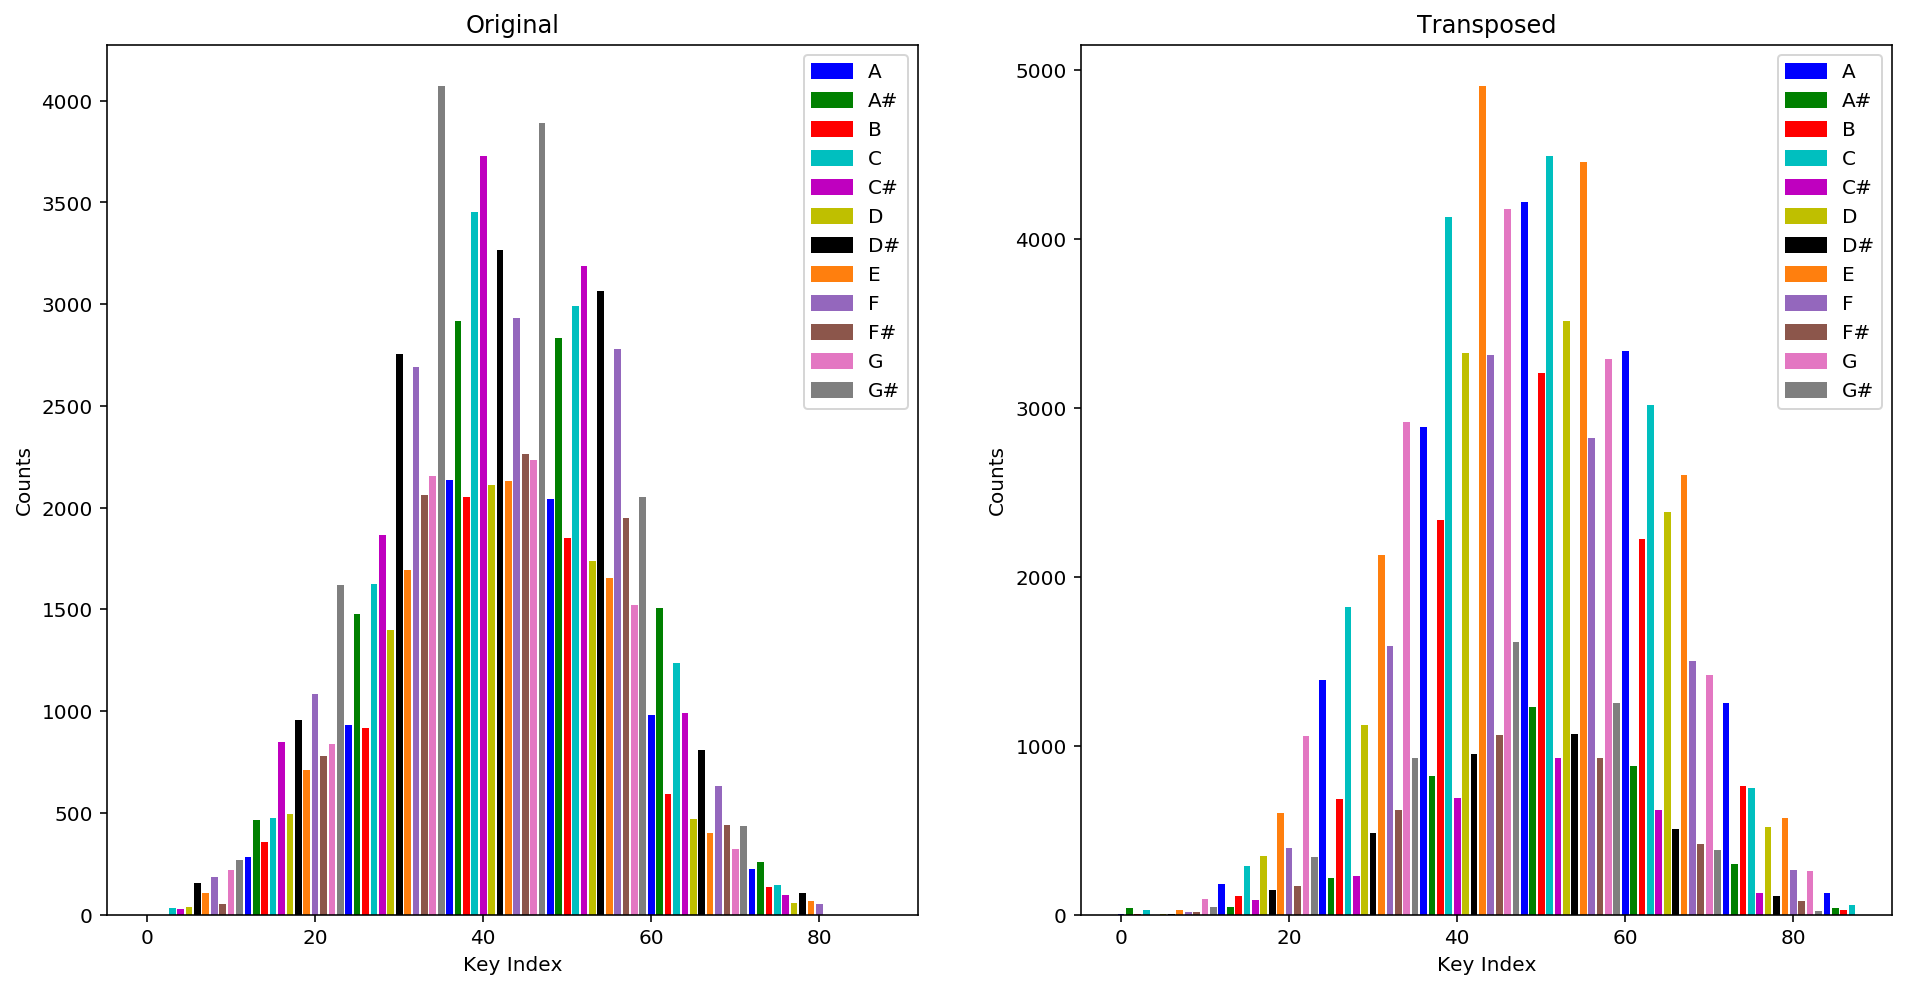

In [17]:
original_piano_key_counts = np.zeros(n_keys_piano)
transposed_piano_key_counts = np.zeros(n_keys_piano)
for i in range(len(chopin_sequences)):
    for j in range(len(chopin_sequences[i])):
        original_piano_key_counts += chopin_sequences[i][j][:-1]  # leave off duration for this analysis
        transposed_piano_key_counts += transposed_chopin_sequences[i][j][:-1]
plt.figure(figsize = (16, 8))
plt.subplot(121)
plt.title('Original')
plt.bar(list(range(n_keys_piano)), original_piano_key_counts, color = colors)
plt.xlabel('Key Index')
plt.ylabel('Counts')
plt.legend(handles, all_notes)
plt.subplot(122)
plt.title('Transposed')
plt.xlabel('Key Index')
plt.ylabel('Counts')
plt.bar(list(range(n_keys_piano)), transposed_piano_key_counts, color = colors)
plt.legend(handles, all_notes)
plt.savefig('../images/original_vs_transposed.png')

Transposing the songs to the key of C has the stark effect of increasing the relative frequency of those notes that belong in the key of C, which, on a piano, is all the white keys (i.e. A, B, C, D, E, F, and G). This should simplify the problem that the neural network needs to solve. When we reach the music generation stage, one can transpose the resulting music into any key as we did here. Also note that the of the distribution has a rightward shift overall. This direction was chosen arbitrarily, and when we transpose generated musical sequences we will do so leftward so as not to increase this rightward shift further. Finally, note that the distribution is more extended than Figure 15 from [here](https://www.tandfonline.com/doi/full/10.1080/25765299.2019.1649972). This suggests that Chopin was more fond of the low and high ends of the keyboard than Bach.

Now would be a good time to convert some sequences back into MIDI format and listen to them
We can make sure the timing is the same between the original and the new, and confirm that the transpose worked

In [18]:
def convert_to_midi(sequence, output_file = 'music.mid'):
    """Save sequence as a midi file (with path = output_file). sequence can be
    from the original dataset or a new sequence generated by a trained model"""
    offset = 0
    output_notes = [instrument.Piano(), tempo.MetronomeMark(number = 60)]
    
    all_notes = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']
    
    # create note, chord, and rest objects
    for vector in sequence:
        converted_duration = duration.Duration()
        converted_duration.quarterLength = vector[-1]     # conveted from seconds, assuming 
                                                          #  bpm = 60 (so beats are eqaul to seconds)
        if (np.sum(vector[:-1]) > 1):  # chord
            indices_in_chord = np.argsort(vector[:-1])[-int(np.sum(vector[:-1])):]
            notes_in_chord = [all_notes[i % 12] + str((i // 12) + 1) for i in indices_in_chord]
            notes = []
            for cur_note in notes_in_chord:
                new_note = note.Note(cur_note)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            new_chord.duration = converted_duration
            output_notes.append(new_chord)
            
        elif (np.sum(vector[:-1]) == 1):   # note
            index = np.argmax(vector[:-1])
            new_note = all_notes[index % 12] + str((index // 12) + 1)
            new_note = note.Note(new_note)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            new_note.duration = converted_duration
            output_notes.append(new_note)
        
        elif (np.sum(vector[:-1]) == 0):   # rest
            new_rest = note.Rest()
            new_rest.offset = offset
            new_rest.duration = converted_duration
            output_notes.append(new_rest)
        offset += vector[-1]
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp = '../midi_output/' + output_file)

In [19]:
index = 0
convert_to_midi(chopin_sequences[index], 'music_{}.mid'.format(index))

Indeed, this midi file is exactly the first few bars of the first imported song (but transposed to C).

Now to apply a window function to get the data into the shape needed for LSTM input

In [20]:
def sequences_to_inputs(sequences, window_size = 16):
    """Apply a window function of size window_size across the dataset to create X. The next 
    vector in the sequence is appended to y for each window. Return X, y."""
    
    X = []
    y = []
    
    for i in range(len(sequences)):
        if (len(sequences[i]) < window_size + 1):
            print("Skipping index ", i, " because the song is too short. Try a shorter window_size to include it.")
            continue
        for j in range(len(sequences[i]) - window_size):
            X.append(sequences[i][j:j + window_size])
            y.append(sequences[i][j + window_size])

    return np.array(X), np.array(y)

In [21]:
X, y = sequences_to_inputs(transposed_chopin_sequences)
                           
X, y = shuffle(X, y, random_state = 42)

Since we will have a sigmoid function applied on the network output, we should have our duration (currently in seconds) in a range \[0, 1\]. We will scale this value by dividing by the maximum duration over the whole set.

In [22]:
maximum_duration = max(X[:, :, -1].max(), y[:, -1].max())
print('Maximum Duration = {}'.format(maximum_duration))
# Keep variable so one can multiply the durations by this after music generation
# to convert back into seconds
X[:, :, -1] /= maximum_duration
y[:, -1] /= maximum_duration

Maximum Duration = 6.545454545454545


What are the dimensions and size of this dataset?

In [23]:
y.shape

(36153, 89)

In [24]:
X.shape

(36153, 16, 89)

In [25]:
print('Dataset size is {} MB'.format(getsizeof(X) / 1000000))

Dataset size is 411.855104 MB


Now to split into train and validation sets (we have no test set since the goal is to generate music using inputs from the validation set)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

We now compute statistics for the duration data which will be used in ./model_training.ipynb to verify the loaded datsets have the same statistics

In [27]:
print('Maximum Scaled Duration for X_train: {}'.format(X_train[:, :, -1].max()))
print('Maximum Scaled Duration for X_val: {}'.format(X_val[:, :, -1].max()))
print('Maximum Scaled Duration for y_train: {}'.format(y_train[:, -1].max()))
print('Maximum Scaled Duration for y_val: {}'.format(y_val[:, -1].max()))

Maximum Scaled Duration for X_train: 0.860215053763441
Maximum Scaled Duration for X_val: 0.5516975308641976
Maximum Scaled Duration for y_train: 1.0
Maximum Scaled Duration for y_val: 0.9166666666666667


In [28]:
print('Train-Validation Ratio of the Mean of the Scaled Duration: ', y_train[:, -1].mean() / y_val[:, -1].mean())
print('Train-Validation Ratio of the Stdv of the Scaled Duration: ', y_train[:, -1].std() / y_val[:, -1].std())

Train-Validation Ratio of the Mean of the Scaled Duration:  0.9898257021922111
Train-Validation Ratio of the Stdv of the Scaled Duration:  0.9209054376139967


In [29]:
np.save('../train_and_val/X_train', X_train)
np.save('../train_and_val/X_val', X_val)
np.save('../train_and_val/y_train', y_train)
np.save('../train_and_val/y_val', y_val)